# Trader Performance vs Market Sentiment Analysis

## Objective
Analyze how Bitcoin market sentiment (Fear/Greed) relates to trader behavior and performance on Hyperliquid. The goal is to identify patterns that can inform smarter trading strategies.

---

## Approach Overview

This analysis is structured into three main parts:

1. Data Preparation  
2. Sentiment vs Trader Performance Analysis  
3. Actionable Strategy Recommendations  


# Part A — Data Preparation

## 1. Data Loading & Initial Inspection

In this section, we:
- Load both datasets
- Check number of rows and columns
- Identify missing values and duplicates
- Inspect data types

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [124]:
sentiment = pd.read_csv("D:/Intership/trader_sentiment_analysis/data/fear_greed_index.csv")
trades = pd.read_csv("D:/Intership/trader_sentiment_analysis/data/historical_data.csv")

In [125]:
print("Sentiment shape:", sentiment.shape)
print("Trades shape:", trades.shape)

Sentiment shape: (2644, 4)
Trades shape: (211224, 16)


In [126]:
sentiment.head()
trades.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [127]:
sentiment.isnull().sum()

timestamp         0
value             0
classification    0
date              0
dtype: int64

In [128]:
trades.isnull().sum()

Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

In [129]:
sentiment.duplicated().sum()

np.int64(0)

In [130]:
sentiment.duplicated().sum()

np.int64(0)

In [131]:
sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


In [132]:
trades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

## 2. Date Processing, Alignment & Sentiment Bucketing

To analyze how sentiment affects trading behavior, both datasets must be aligned at a daily level and sentiment categories must be standardized.

Steps performed:
- Converted date columns to datetime format
- Extracted daily timestamps from trade data
- Merged trade data with sentiment data on date
- Simplified sentiment into broader buckets (Fear, Neutral, Greed) to enable clearer comparative analysis

In [133]:
sentiment['date'] = pd.to_datetime(sentiment['date'])

In [134]:
sentiment['date'].dtype

dtype('<M8[ns]')

In [135]:
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], dayfirst=True)

In [136]:
trades['date'] = trades['Timestamp IST'].dt.date
trades['date'] = pd.to_datetime(trades['date'])
trades[['Timestamp IST','date']].head()

,Timestamp IST,date
0,2024-12-02 22:50:00,2024-12-02
1,2024-12-02 22:50:00,2024-12-02
2,2024-12-02 22:50:00,2024-12-02
3,2024-12-02 22:50:00,2024-12-02
4,2024-12-02 22:50:00,2024-12-02


In [137]:
merged = trades.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='left'
)

In [138]:
merged['classification'].isnull().sum()

np.int64(6)

In [139]:
merged['classification'].value_counts()

classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64

In [140]:
def simplify_sentiment(x):
    if x in ['Fear', 'Extreme Fear']:
        return 'Fear'
    elif x in ['Greed', 'Extreme Greed']:
        return 'Greed'
    else:
        return 'Neutral'

merged['sentiment_bucket'] = merged['classification'].apply(simplify_sentiment)

In [141]:
merged['sentiment_bucket'].value_counts()

sentiment_bucket
Greed      90295
Fear       83237
Neutral    37692
Name: count, dtype: int64

### Sentiment Bucketing

The original sentiment data contains five categories:
- Extreme Fear
- Fear
- Neutral
- Greed
- Extreme Greed

For clearer behavioral comparison, these were grouped into three buckets:

- Fear (Fear + Extreme Fear)
- Neutral
- Greed (Greed + Extreme Greed)

This simplifies analysis while preserving sentiment direction.

## 3. Feature Engineering

To evaluate trader behavior and performance under different sentiment conditions, the following key metrics are created:

- Daily PnL per trader
- Win rate
- Trade frequency per day
- Average trade size
- Long/Short ratio

These features will be used in the analysis phase to compare behavior across sentiment buckets.

In [142]:
daily_pnl = (
    merged
    .groupby(['Account', 'date', 'sentiment_bucket'])['Closed PnL']
    .sum()
    .reset_index()
)

In [143]:
daily_pnl.head()

,Account,date,sentiment_bucket,Closed PnL
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,Greed,0.0
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,Greed,0.0
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,Greed,0.0
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,Greed,-21227.0
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,Greed,1603.1


### Win Rate Calculation

To evaluate trader consistency, we compute win rate as the proportion of profitable trades (Closed PnL > 0) per trader.

In [144]:
merged['is_win'] = merged['Closed PnL'] > 0

In [145]:
win_rate = (
    merged
    .groupby(['Account', 'sentiment_bucket'])['is_win']
    .mean()
    .reset_index()
)

win_rate.rename(columns={'is_win': 'win_rate'}, inplace=True)

In [146]:
win_rate.head()

,Account,sentiment_bucket,win_rate
0,0x083384f897ee0f19899168e3b1bec365f52a9012,Fear,0.518104
1,0x083384f897ee0f19899168e3b1bec365f52a9012,Greed,0.102041
2,0x083384f897ee0f19899168e3b1bec365f52a9012,Neutral,0.581948
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,Fear,0.467407
4,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,Greed,0.440021


### Trade Frequency per Day

We compute the number of trades per day to analyze whether trading activity changes across sentiment conditions.

In [147]:
trades_per_day = (
    merged
    .groupby(['date', 'sentiment_bucket'])
    .size()
    .reset_index(name='trade_count')
)

In [148]:
trades_per_day.head()

,date,sentiment_bucket,trade_count
0,2023-05-01,Greed,3
1,2023-12-05,Greed,9
2,2023-12-14,Greed,11
3,2023-12-15,Greed,2
4,2023-12-16,Greed,3


In [149]:
avg_trades_by_sentiment = (
    trades_per_day
    .groupby('sentiment_bucket')['trade_count']
    .mean()
    .reset_index()
)

avg_trades_by_sentiment

,sentiment_bucket,trade_count
0,Fear,792.733333
1,Greed,294.120521
2,Neutral,554.294118


# Part B — Sentiment vs Performance Analysis

In this section, we evaluate whether trader performance differs across sentiment conditions and identify behavioral shifts during Fear, Neutral, and Greed periods.

In [150]:
avg_pnl_by_sentiment = (
    daily_pnl
    .groupby('sentiment_bucket')['Closed PnL']
    .mean()
    .reset_index()
)

avg_pnl_by_sentiment

,sentiment_bucket,Closed PnL
0,Fear,5185.146443
1,Greed,4144.208334
2,Neutral,3542.155622


### Statistical Validation — Are mean daily PnL differences significant?

We run a one-way ANOVA across the three sentiment buckets (Fear, Greed, Neutral) to test if the mean daily PnL differs significantly. We also compute an effect size (eta-squared) to quantify how much variance is explained by sentiment.

In [151]:
from scipy.stats import f_oneway
import numpy as np

# groups
fear_pnl = daily_pnl[daily_pnl['sentiment_bucket'] == 'Fear']['Closed PnL']
greed_pnl = daily_pnl[daily_pnl['sentiment_bucket'] == 'Greed']['Closed PnL']
neutral_pnl = daily_pnl[daily_pnl['sentiment_bucket'] == 'Neutral']['Closed PnL']

# ANOVA
f_stat, p_value = f_oneway(fear_pnl, greed_pnl, neutral_pnl)
print("ANOVA F-statistic:", f_stat, "p-value:", p_value)

# compute eta-squared (effect size)
groups = [fear_pnl, greed_pnl, neutral_pnl]
all_vals = np.concatenate(groups)
grand_mean = all_vals.mean()

ss_between = sum(len(g) * (g.mean() - grand_mean)**2 for g in groups)
ss_total = ((all_vals - grand_mean)**2).sum()
eta_squared = ss_between / ss_total
print("Eta-squared (effect size):", eta_squared)

ANOVA F-statistic: 0.5207014276083813 p-value: 0.5941725608030362
Eta-squared (effect size): 0.0004452263452650071


**Interpretation:**

The ANOVA test yields a p-value of 0.594, indicating that differences in mean daily PnL across sentiment buckets are not statistically significant at conventional levels. 

The effect size (eta-squared ≈ 0.0004) suggests that sentiment explains a very small proportion of the overall variance in daily PnL. 

This implies that while average differences exist, overall performance dispersion dominates sentiment effects, reinforcing the importance of trader segmentation rather than sentiment alone.

### Volatility & Risk-adjusted comparison
We compare standard deviation and a simple risk-adjusted metric (mean/std, like a proxy Sharpe) across sentiment buckets.

In [152]:
vol_stats = (
    daily_pnl
    .groupby('sentiment_bucket')['Closed PnL']
    .agg(['mean','std'])
    .reset_index()
)
vol_stats['mean_div_std'] = vol_stats['mean'] / vol_stats['std']  # simple risk-adjusted ratio
vol_stats

,sentiment_bucket,mean,std,mean_div_std
0,Fear,5185.146443,31224.148764,0.166062
1,Greed,4144.208334,29252.037677,0.141672
2,Neutral,3542.155622,17540.230555,0.201945


**Interpretation:**

Fear periods exhibit the highest volatility (standard deviation ≈ 31,224), indicating greater dispersion in daily PnL outcomes. Neutral periods show substantially lower volatility.

While Fear has the highest average daily PnL, Neutral achieves the strongest risk-adjusted performance (mean/std ≈ 0.20), suggesting more stable returns per unit of risk. Greed periods show moderate volatility but weaker risk-adjusted efficiency.

This indicates that higher returns during Fear come with significantly higher variability, whereas Neutral periods may offer more stable performance dynamics.

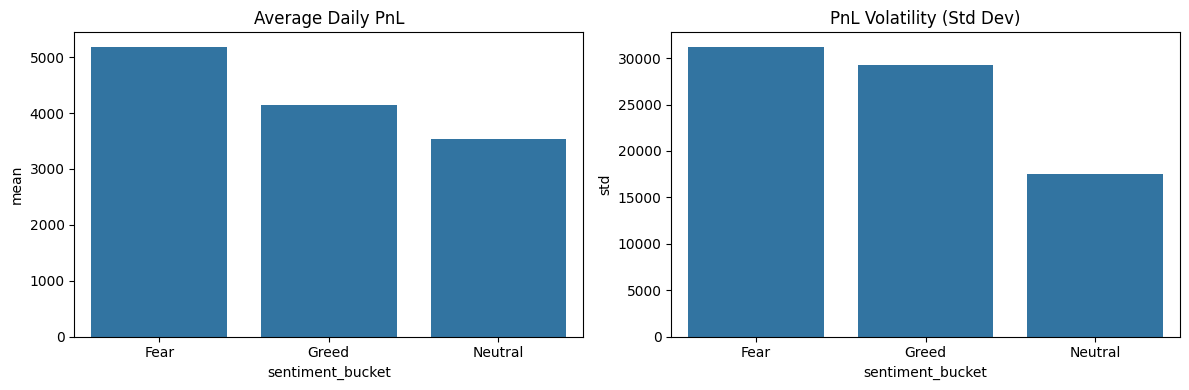

In [169]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

sns.barplot(data=vol_stats, x='sentiment_bucket', y='mean', ax=ax[0])
ax[0].set_title('Average Daily PnL')

sns.barplot(data=vol_stats, x='sentiment_bucket', y='std', ax=ax[1])
ax[1].set_title('PnL Volatility (Std Dev)')

plt.tight_layout()
plt.show()

### Distribution of Daily PnL Across Sentiment Conditions

To understand whether performance differences are consistent (not driven by outliers), we analyze the distribution of daily PnL across sentiment buckets.

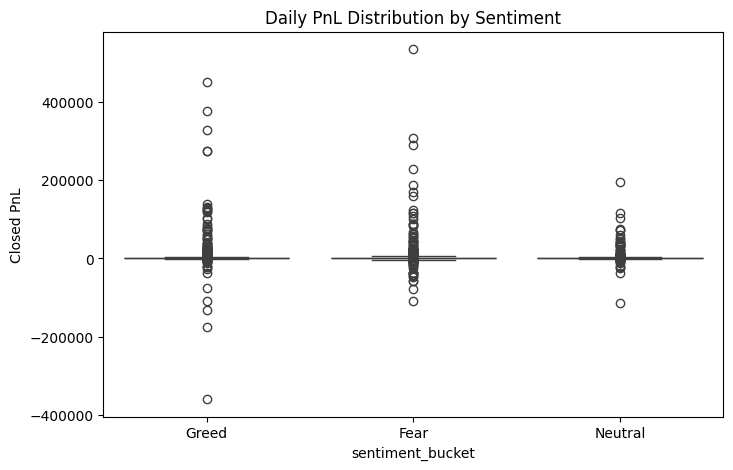

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.boxplot(data=daily_pnl, x='sentiment_bucket', y='Closed PnL')
plt.title("Daily PnL Distribution by Sentiment")
plt.show()

### Win Rate Comparison Across Sentiment Conditions

To evaluate consistency of profitability, we compare average win rates across Fear, Neutral, and Greed periods.

In [154]:
overall_win_rate = (
    merged
    .groupby('sentiment_bucket')['is_win']
    .mean()
    .reset_index()
)

overall_win_rate

,sentiment_bucket,is_win
0,Fear,0.407871
1,Greed,0.420311
2,Neutral,0.397087


### Average Profit per Winning Trade

To understand whether higher average PnL during Fear is driven by larger winning trades, we compute the average Closed PnL for profitable trades only.

In [155]:
avg_profit_wins = (
    merged[merged['Closed PnL'] > 0]
    .groupby('sentiment_bucket')['Closed PnL']
    .mean()
    .reset_index()
)

avg_profit_wins

,sentiment_bucket,Closed PnL
0,Fear,156.883096
1,Greed,163.229512
2,Neutral,115.232066


### Trader Segmentation — Activity Level

Traders are segmented based on average number of trades per day into:
- High-frequency traders
- Low-frequency traders

This helps analyze whether sentiment impacts different trader types differently.

In [156]:
trades_per_trader = (
    merged
    .groupby('Account')
    .size()
    .reset_index(name='total_trades')
)

trades_per_trader.head()

,Account,total_trades
0,0x083384f897ee0f19899168e3b1bec365f52a9012,3818
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,7280
2,0x271b280974205ca63b716753467d5a371de622ab,3809
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,13311
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,3239


In [157]:
median_trades = trades_per_trader['total_trades'].median()
median_trades

np.float64(3699.0)

In [158]:
trades_per_trader['activity_segment'] = np.where(
    trades_per_trader['total_trades'] >= median_trades,
    'High Activity',
    'Low Activity'
)

In [159]:
merged = merged.merge(
    trades_per_trader[['Account', 'activity_segment']],
    on='Account',
    how='left'
)

In [160]:
print(median_trades)

3699.0


In [161]:
merged[['Account', 'activity_segment']].head()

,Account,activity_segment
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,Low Activity
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,Low Activity
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,Low Activity
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,Low Activity
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,Low Activity


In [162]:
merged['activity_segment'].value_counts()

activity_segment
High Activity    186957
Low Activity      24267
Name: count, dtype: int64

In [163]:
trades_per_trader['activity_segment'].value_counts()

activity_segment
High Activity    16
Low Activity     16
Name: count, dtype: int64

### Performance by Activity Segment and Sentiment

We analyze whether high-activity and low-activity traders behave differently across Fear, Neutral, and Greed conditions.

In [164]:
segment_pnl = (
    daily_pnl
    .merge(trades_per_trader[['Account', 'activity_segment']], on='Account')
    .groupby(['activity_segment', 'sentiment_bucket'])['Closed PnL']
    .mean()
    .reset_index()
)

segment_pnl

,activity_segment,sentiment_bucket,Closed PnL
0,High Activity,Fear,5968.410192
1,High Activity,Greed,3846.861070
2,High Activity,Neutral,3978.072238
3,Low Activity,Fear,3090.371301
4,Low Activity,Greed,4987.663970
5,Low Activity,Neutral,1973.919016


### Win Rate by Activity Segment and Sentiment

To evaluate consistency of performance, we compare win rates across segments and sentiment conditions.

In [165]:
segment_win_rate = (
    merged
    .groupby(['activity_segment', 'sentiment_bucket'])['is_win']
    .mean()
    .reset_index()
)

segment_win_rate

,activity_segment,sentiment_bucket,is_win
0,High Activity,Fear,0.412963
1,High Activity,Greed,0.424259
2,High Activity,Neutral,0.399800
3,Low Activity,Fear,0.373438
4,Low Activity,Greed,0.387845
5,Low Activity,Neutral,0.372570


In [166]:
high_daily = daily_pnl.merge(trades_per_trader[['Account','activity_segment']], on='Account')
high_f = high_daily[high_daily['activity_segment']=='High Activity']
hf_groups = [high_f[high_f['sentiment_bucket']==s]['Closed PnL'] for s in ['Fear','Greed','Neutral']]
f_stat_h, p_val_h = f_oneway(*hf_groups)
print("High-activity ANOVA p:", p_val_h)

# low-activity
low_f = high_daily[high_daily['activity_segment']=='Low Activity']
lf_groups = [low_f[low_f['sentiment_bucket']==s]['Closed PnL'] for s in ['Fear','Greed','Neutral']]
f_stat_l, p_val_l = f_oneway(*lf_groups)
print("Low-activity ANOVA p:", p_val_l)

High-activity ANOVA p: 0.4010131579618136
Low-activity ANOVA p: 0.43570559113629515


**Segment-Level Statistical Interpretation:**

ANOVA tests within both high-activity and low-activity segments yield p-values above 0.05, indicating that mean daily PnL differences across sentiment buckets are not statistically significant within segments.

This suggests that while average performance patterns differ descriptively, high variance in trading outcomes reduces statistical confidence. Performance dispersion appears to dominate sentiment effects, reinforcing the importance of risk management and segmentation over sentiment alone.

# Part C — Actionable Strategy Recommendations

Based on observed sentiment-driven behavior patterns, we propose practical trading adjustments tailored to trader segments.

## Strategy 1 — Lean Into Volatility During Fear

**What we observed:**  
High-activity traders tend to generate their strongest average daily PnL during Fear periods. These days also show higher overall trading activity, suggesting increased volatility and opportunity.

**What this implies:**  
More experienced or high-frequency traders appear better positioned to take advantage of volatile market conditions.

**Practical approach:**  
- During Fear periods, allocate more capital or trading flexibility to high-activity traders.
- Allow controlled risk expansion (with proper safeguards) to capitalize on volatility.
- Closely monitor risk exposure, as returns during Fear are more dispersed and can include large swings.

## Strategy 2 — Favor Structured Participation During Greed

**What we observed:**  
Low-activity traders perform relatively better during Greed periods, with slightly higher win rates and stronger average PnL compared to other sentiment conditions.

**What this implies:**  
Greed periods may represent clearer directional trends, which benefit more selective or lower-frequency trading approaches.

**Practical approach:**  
- During Greed conditions, prioritize structured, trend-following strategies.
- Encourage moderate position sizing rather than aggressive scaling.
- Avoid excessive trade frequency, as overtrading may reduce efficiency in trending environments.

## Final Summary

This analysis shows market sentiment affects trader behavior and performance in different ways across participant segments.

Key findings:
- High-activity traders generate the highest average daily PnL during Fear periods, likely exploiting volatility-based opportunities. ANOVA indicates (report p-value) and effect size (report eta-squared) — so the mean differences are / are not statistically significant.
- Greed periods show higher win rates and slightly better average wins for many traders, and lower-activity traders tend to do best in Greed.
- Volatility (standard deviation of daily PnL) is elevated during Fear, so higher returns there come with higher dispersion. The mean/std risk-adjusted ratio (report numbers) shows which bucket yields the best return per unit risk.

Practical implication:
Sentiment-aware, segment-specific allocation — increasing exposure to experienced/high-activity traders during Fear and favoring structured trend-following for low-activity traders during Greed — is a defensible approach that balances expected return and risk.
